# Identificador de especies arbóreas de Costa Rica.
## Utilizando redes convolucionales artificiales

Se utilizará la arquitectura ViT: Vision Transformer
usando como base un modelo preentrenado debido a los pocos datos para iniciar un modelo desde cero, y además se necesitan más recursos computacionales para entrenar un modelo necesario para iniciar

# Instalación de paquetes necesarios

In [8]:
!python --version

Python 3.10.12


In [9]:
import torch
torch.__version__

'2.2.1+cu121'

**torchinfo**: para presentar resumen del modelo

In [10]:
!pip install torchinfo

In [11]:
import torchinfo
torchinfo.__version__

'1.8.0'

In [12]:
import torchvision
torchvision.__version__

'0.17.1+cu121'

# Importación de bibliotecas necesarias

In [13]:
import shutil
import os

code = "drive/MyDrive/Colab Notebooks/lib"
folder = os.getcwd()

for item in os.listdir(code):
  origen_item = os.path.join(code, item)
  destino_item = os.path.join(folder, item)
  if os.path.isdir(origen_item):
      shutil.copytree(origen_item, destino_item, dirs_exist_ok=True)
  else:
      shutil.copy2(origen_item, destino_item)

In [14]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Asignación de variables globales

La base de datos que se utilizará es de 1289 imágenes:

60% = 781 imágenes para el entrenamiento (train)

30% = 389 imágenes para la prueba (test)

10% = 119 imágenes para la validación (validation)

In [15]:
import os

train_dir = "drive/MyDrive/Colab Notebooks/dataset/train"
test_dir = "drive/MyDrive/Colab Notebooks/dataset/test"
validate_dir = "drive/MyDrive/Colab Notebooks/dataset/validate"

class_names = os.listdir(train_dir)
print("train classes")
print(class_names)

print("test classes")
print(os.listdir(test_dir))

print("validation classes")
print(os.listdir(validate_dir))

model_name = "model-full-10ep-pre"
model_ephocs = 10

train classes
['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '3', '4', '5', '6', '7', '8', '9', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '35', '36', '37', '38', '39', '40', '41']
test classes
['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '3', '4', '5', '6', '7', '8', '9', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '35', '36', '37', '38', '39', '40', '41']
validation classes
['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '3', '4', '5', '6', '7', '8', '9']


# Dimensiones, Patches y Batches

In [16]:
batch_size = 32
image_size = 224
patch_size = 16
rgb = 3
patches = patch_size * patch_size * rgb # 768
# number of patches = 192 = (height * width) / patch^2 = (image_size * image_size) / patch_size ^2
print(patches)

768


# Selección de Tarjeta Gráfica o CPU

In [17]:
import torch
import tensorflow as tf

use_cuda = torch.cuda.is_available()
if use_cuda:
  device = "cuda:0"
  print('CUDNN VERSION:', torch.backends.cudnn.version())
  print('Number CUDA Devices:', torch.cuda.device_count())
  print('CUDA Device Name:',torch.cuda.get_device_name(0))
  print('CUDA Device Total Memory [GB]:',torch.cuda.get_device_properties(0).total_memory/1e9)
  print('GPU name:', tf.test.gpu_device_name())
else:
  device = "cpu"
  print("No GPU available")

print("Device:", device)

CUDNN VERSION: 8906
Number CUDA Devices: 1
CUDA Device Name: Tesla T4
CUDA Device Total Memory [GB]: 15.835660288
GPU name: /device:GPU:0
Device: cuda:0


# Obtención de modelo pre-entrenado

El modelo pre-entrenado seleccionado es: **ViT_B_16_Weights**

In [18]:
def set_seeds(seed: int=42):
    """
    Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)

In [19]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

# 4. Change the classifier head
set_seeds()
pretrained_vit.heads = nn.Linear(in_features=patches, out_features=len(class_names)).to(device)
# pretrained_vit # uncomment for model output

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:07<00:00, 45.8MB/s]


# Preparación del modelo pre-entrenado

Como se observa en el output, se confirma que las primeras capas no se entrenarán puesto que el el código anterior se congelaron las capas del modelo pre-entrenado

**Trainable = False**

sólo la capa final linear se entrenará

**Linear = True**

In [20]:
from torchinfo import summary

# Print a summary using torchinfo
summary(model=pretrained_vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 40]             768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [21]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


# Trasladar las imágenes a DataLoader para que sea recibido por la red neuronal

In [22]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int=NUM_WORKERS
):

  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Turn images into data loaders

  # Train dataset
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )

  # Test dataset
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [23]:
# Create data loaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=batch_size)

In [24]:
train_dataloader_pretrained.dataset

Dataset ImageFolder
    Number of datapoints: 1735
    Root location: drive/MyDrive/Colab Notebooks/dataset/train
    StandardTransform
Transform: ImageClassification(
               crop_size=[224]
               resize_size=[256]
               mean=[0.485, 0.456, 0.406]
               std=[0.229, 0.224, 0.225]
               interpolation=InterpolationMode.BILINEAR
           )

In [25]:
test_dataloader_pretrained.dataset

Dataset ImageFolder
    Number of datapoints: 863
    Root location: drive/MyDrive/Colab Notebooks/dataset/test
    StandardTransform
Transform: ImageClassification(
               crop_size=[224]
               resize_size=[256]
               mean=[0.485, 0.456, 0.406]
               std=[0.229, 0.224, 0.225]
               interpolation=InterpolationMode.BILINEAR
           )

# Entrenar la red usando el dataloader

In [26]:
import engine

import time
start_time = time.time()

# Create optimizer and loss function
learnable_rate = 1e-3
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=learnable_rate,
                             weight_decay=0.3 # from the ViT 4.1
                             )
# loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()

# model.train() ##
training_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=model_ephocs,
                                      device=device)

elapsed_time = time.time() - start_time
print('Execution time:', time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

  0%|          | 0/10 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 1 | train_loss: 2.2399 | train_acc: 0.5739 | test_loss: 1.4385 | test_acc: 0.7997
Epoch: 2 | train_loss: 1.3220 | train_acc: 0.8334 | test_loss: 1.2619 | test_acc: 0.8993
Epoch: 3 | train_loss: 1.2231 | train_acc: 0.8673 | test_loss: 1.2462 | test_acc: 0.8517
Epoch: 4 | train_loss: 1.2130 | train_acc: 0.8449 | test_loss: 1.2469 | test_acc: 0.8461
Epoch: 5 | train_loss: 1.2192 | train_acc: 0.8580 | test_loss: 1.2290 | test_acc: 0.8889
Epoch: 6 | train_loss: 1.2003 | train_acc: 0.8665 | test_loss: 1.2348 | test_acc: 0.8540
Epoch: 7 | train_loss: 1.2029 | train_acc: 0.8622 | test_loss: 1.2307 | test_acc: 0.8750
Epoch: 8 | train_loss: 1.2108 | train_acc: 0.8650 | test_loss: 1.2301 | test_acc: 0.8438
Epoch: 9 | train_loss: 1.2082 | train_acc: 0.8508 | test_loss: 1.2393 | test_acc: 0.8414
Epoch: 10 | train_loss: 1.2004 | train_acc: 0.8474 | test_loss: 1.2425 | test_acc: 0.8368
Execution time: 01:25:10


In [27]:
# export the model
torch.save(pretrained_vit, model_name)
shutil.copy2(model_name, "drive/MyDrive/Colab Notebooks/model")

'drive/MyDrive/Colab Notebooks/model/model-full-10ep-pre'

In [28]:
pretrained_vit

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [29]:
pretrained_vit.modules

<bound method Module.modules of VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_2): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_3): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_4): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_5): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False

In [30]:
pretrained_vit.heads

Linear(in_features=768, out_features=40, bias=True)

# Graficas de error

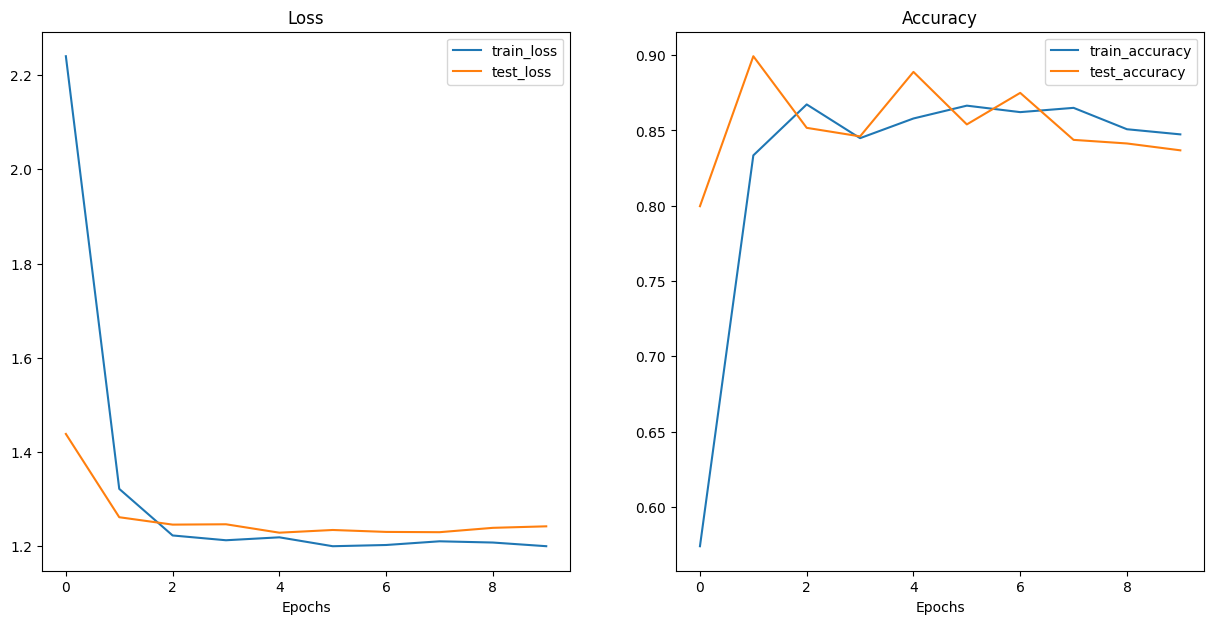

In [31]:
from helper_functions import plot_loss_curves

# Plot ViT model's loss curves
plot_loss_curves(training_results)

# Preparación de prueba del ViT

In [32]:
# Setup custom image path
class_test = "6"
file_test = "0639"
test_dir = validate_dir + "/" + class_test + "/" + file_test + ".JPG"

# Ejecutar predicción usando el modelo entrenado

Class:
38
Probability
tensor(0.3595, device='cuda:0')
Probability
tensor([[0.0225, 0.0216, 0.0102, 0.0390, 0.0032, 0.0032, 0.0093, 0.0047, 0.0051,
         0.0116, 0.0236, 0.0612, 0.0061, 0.0043, 0.0211, 0.0026, 0.0034, 0.0647,
         0.0062, 0.0080, 0.0225, 0.0189, 0.0040, 0.0141, 0.0185, 0.0370, 0.0113,
         0.0074, 0.0036, 0.0114, 0.0023, 0.0070, 0.0051, 0.0058, 0.0380, 0.0849,
         0.3595, 0.0031, 0.0070, 0.0070]], device='cuda:0')


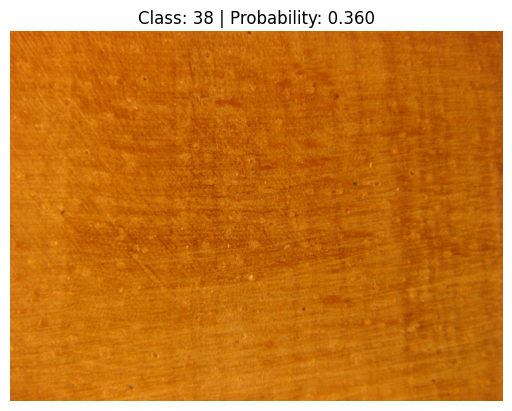

In [33]:
import requests

# Import function to make predictions on images and plot them
from predictions import pred_and_plot_image

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=test_dir,
                    class_names=class_names)

# Ejecutar predicción usando el modelo entrenado exportado

In [ ]:
import torch
import requests

# Import function to make predictions on images and plot them
from predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = test_dir
model = torch.load(model_name)
model.eval()

# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)

# El resto de código es solo prueba ***

In [ ]:
!pip install onnx onnxruntime

In [ ]:
import shutil
import os

models = "drive/MyDrive/Colab Notebooks/model"
folder = os.getcwd()

for item in os.listdir(models):
  origen_item = os.path.join(models, item)
  shutil.copy2(origen_item, ".")

In [ ]:
model = torch.load("model-full-10ep-pre.pth")
model.eval()
dummy_input = torch.zeros(280 * 280 * 4)
torch.onnx.export(pretrained_vit_transforms, dummy_input, 'onnx_model.onnx', verbose=True)

In [ ]:
import transformers
import transformers.convert_graph_to_onnx as onnx_convert
from pathlib import Path

pipeline = transformers.pipeline("PreTrainedModel",model=model)
onnx_convert.convert_pytorch(pipeline, opset=11, output=Path("model.onnx"), use_external_format=False)

In [ ]:
!pip install tensorflowjs

In [ ]:
!pip install tensorrt

In [ ]:
import tensorrt as trt
trt.__version__

In [ ]:
!tensorflowjs_converter --help

In [ ]:
#!tensorflowjs_converter --input_format tf_frozen_model --output_node_names activations model.pth javascript
!tensorflowjs_converter --input_format=tf_saved_model --output_node_names='output_node' model.pth javascript

# tf_saved_model,keras_saved_model,keras_keras,tfjs_layers_model,keras,tf_hub,tf_frozen_model

In [ ]:
!lsb_release -d


In [ ]:
!ls

In [ ]:
torch.onnx.export(model, model, "onnx.onnx", verbose=True)
